<img src="escuela-de-economia.png" width="260" height="60">
<center>
    <b>EC4301 MACROECONOMETRÍA</b><br>
    <b>Profesor:  Randall Romero Aguilar, PhD</b>
<br><br>
<b>Laboratorio:</b>
<div style="font-size:175%;color:white; background-color: #0064b0;">Tema 10: Vectores autorregresivos (VAR)</div>
<div style="font-size:250%;color:white; background-color: #0064b0;">Simulación de un VAR(1)</div> 
</center>
<i>Creado:     2017-May-16 
    <br>
    Actualizado: 2020-Oct-25</i>

# Simulación de un VAR(1)

Suponga el siguiente modelo dinámico

\begin{align} 
x_t &= 4 + 0.8x_{t-1} + y_{t-1} + \epsilon_{x,t} \\
y_t &= 1 + 0.1x_{t-1} + 0.5y_{t-1} + \epsilon_{y,t}
\end{align}

que puede escribirse
$$
\underset{X_t}{\begin{pmatrix}x_t \\ y_t\end{pmatrix}} = 
\underset{c}{\begin{pmatrix}0.9 \\ 1.8\end{pmatrix}} +
\underset{A}{\begin{pmatrix}0.8 & 0.7 \\ -0.2 & 0.8\end{pmatrix}}
\underset{X_{t-1}}{\begin{pmatrix}x_{t-1} \\ y_{t-1}\end{pmatrix}} +
\underset{\epsilon_t}{\begin{pmatrix}\epsilon_{x,t} \\ \epsilon_{y,t}\end{pmatrix}}
$$

con matriz de correlaciones de los errores reducidos
$$
\Omega = E\left[\underset{\epsilon_t}{\begin{pmatrix}\epsilon_{x,t} \\ \epsilon_{y,t}\end{pmatrix}}\underset{\epsilon'_t}{\begin{pmatrix}\epsilon_{x,t} & \epsilon_{y,t}\end{pmatrix}}\right] =
E\begin{pmatrix}\epsilon^2_{x,t} & \epsilon_{x,t}\epsilon_{y,t} \\ \epsilon_{y,t}\epsilon_{x,t} & \epsilon^2_{y,t}\end{pmatrix} =
\begin{pmatrix}0.0400 & 0.0280 \\ 0.0280 & 0.0596\end{pmatrix}
$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
from statsmodels.tsa.api import VAR


%matplotlib inline

## Simulando los datos 

Vamos a simular una muestra de 100 observaciones de un VAR(1). Empezamos por ingresar los valores de los parámetros

In [2]:
T = 100

A = np.array([[0.8, 0.7], [-0.2, 0.8]])
c = np.array([[0.9], [1.8]])

In [3]:
Ω = 0.04*np.array([[1, 0.7],[0.7,1.49]])

Calculamos la descomposición de Cholesky para poder simular la correlación de los errores

In [4]:
P = np.linalg.cholesky(Ω)
P

array([[0.2 , 0.  ],
       [0.14, 0.2 ]])

Fijamos una semilla para el generador de números aleatorios, para obtener resultados replicables.

In [5]:
np.random.seed(16)

Calculamos la media del proceso $\mu = (I-A)^{1}c$ y lo usamos como valor inicial de la simulación.

In [6]:
𝜇 = (np.linalg.inv(np.eye(2) - A) @ c)

X = np.zeros((T,2))
X[0] = 𝜇.T

for t in range(1, T):
    X[t] = c.T + X[t-1] @ A.T + np.random.randn(2) @ P.T

Guardamos los datos simulados como un DataFrame de pandas y los graficamos

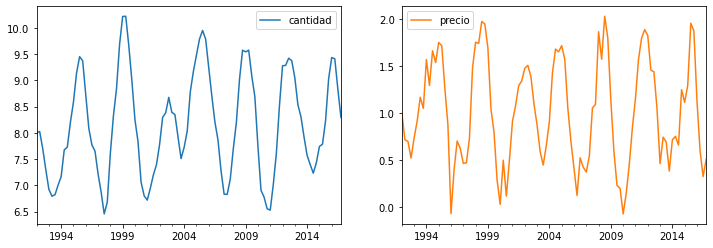

In [7]:
trimestres = pd.date_range(start='1992q1', freq='Q', periods=T)
data = pd.DataFrame(X, columns=['cantidad', 'precio'], index=trimestres)

fig, axs = plt.subplots(1,2,figsize=[12,4])
data.plot(subplots=True, ax=axs);

## Determinando si el VAR es estable

Para ello calculamos los valores propios de la matriz A, y comprobamos si estan en el círculo unitario

Los eigenvalores son  [0.8+0.37416574j 0.8-0.37416574j]
y sus modulos son [0.88317609 0.88317609]


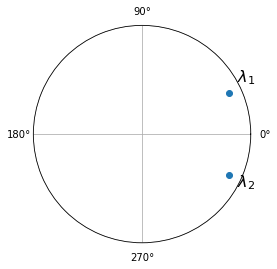

In [8]:
eigenvalues = np.linalg.eigvals(A)
print('Los eigenvalores son ', eigenvalues)
print('y sus modulos son', abs(eigenvalues))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, polar=True)

ax.plot(np.angle(eigenvalues), abs(eigenvalues),marker='o',linewidth=0)
ax.set(ylim=[0,1], yticks=[1], yticklabels=[''], xticks=np.arange(4)*np.pi/2)

ax.annotate('$\lambda_1$',[0.5,1.0], fontsize=16)
ax.annotate('$\lambda_2$',[-0.5,1.0], fontsize=16);


## Estimación del VAR a partir de los datos simulados

In [9]:
model = VAR(data)

Determinamos el rezago óptimo

In [10]:
model.select_order(5).summary()

,AIC,BIC,FPE,HQIC
0,-1.168,-1.114,0.3110,-1.146
1,-6.478*,-6.316*,0.001537*,-6.412*
2,-6.460,-6.191,0.001566,-6.351
3,-6.389,-6.012,0.001681,-6.237
4,-6.359,-5.875,0.001733,-6.163
5,-6.311,-5.720,0.001819,-6.072


Estimamos el VAR con un único rezago

In [11]:
results = model.fit(maxlags=1)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 25, Oct, 2020
Time:                     18:13:17
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -6.33706
Nobs:                     99.0000    HQIC:                  -6.43071
Log likelihood:           46.5202    FPE:                 0.00151202
AIC:                     -6.49434    Det(Omega_mle):      0.00142439
--------------------------------------------------------------------
Results for equation cantidad
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.822641         0.155447            5.292           0.000
L1.cantidad         0.808834         0.019385           41.726           0.000
L1.precio           0.731017         0.034625           21.112   

## Pruebas de causalidad de Granger

En ambos casos, las pruebas confirman que una variable tiene capacidad predictiva sobre la otra variable.

In [12]:
results.test_causality('precio', 'cantidad').summary()

Test statistic,Critical value,p-value,df
71.66,3.890,0.000,"(1, 192)"


In [13]:
results.test_causality('cantidad', 'precio').summary()

Test statistic,Critical value,p-value,df
445.7,3.890,0.000,"(1, 192)"


## Funciones de impulso respuesta

Simulamos impulsos unitarios. A la izquierda, el impulso es $\begin{pmatrix}1 \\ 0\end{pmatrix}$ (un choque de una unidad en la cantidad); a la derecha el impulso es $\begin{pmatrix}0 \\ 1\end{pmatrix}$ (un choque de una unidad en el precio).

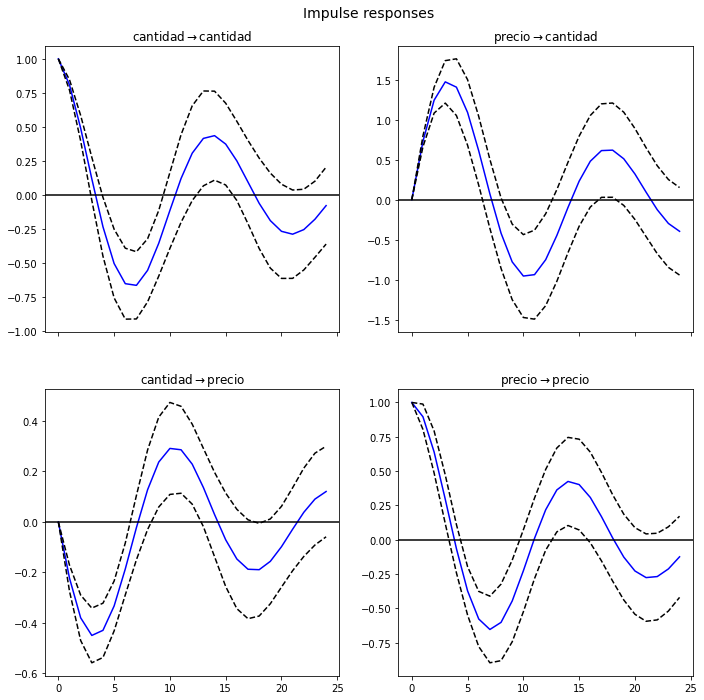

In [14]:
results.irf(24).plot();

## Pronosticando los siguientes datos

Vemos que después de un tiempo los pronósticos convergen a la media estimada del proceso (en rojo).

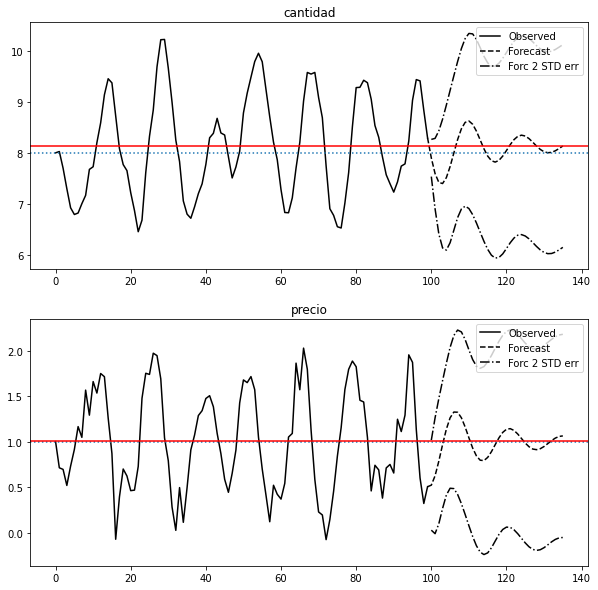

In [15]:
fig = results.plot_forecast(36)

for i in range(2):
    fig.axes[i].axhline(𝜇[i], ls=':')
    fig.axes[i].axhline(results.mean()[i], color='r')
